<h2>Formula 1 Grand Prix result prediction</h2>

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.model_selection import train_test_split,KFold,GridSearchCV
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
import pickle
from lightgbm import LGBMRegressor, plot_importance

plt.style.use('bmh')
pd.set_option('display.float_format', '{:.2f}'.format)

<h3>Data cleaning</h3>

In [12]:
results = pd.read_csv(r'testdata/results.csv')
races = pd.read_csv(r'testdata/races.csv')
qualifyings = pd.read_csv(r'testdata/qualifying.csv')
drivers = pd.read_csv(r'testdata/drivers.csv')
constructors = pd.read_csv(r'testdata/constructors.csv')
circuits = pd.read_csv(r'testdata/circuits.csv')
status = pd.read_csv(r'testdata/status.csv')
laptimes = pd.read_csv(r'testdata/lap_times.csv')


countries = pd.read_csv(r'data/countries/countries.csv')

In [13]:
df1 = pd.merge(races,results,how='left',on=['raceId'], suffixes=('_race', '_result'))
df2 = pd.merge(df1,qualifyings,how='left',on=['raceId','driverId','constructorId'], suffixes=('', '_qualifying'))
df3 = pd.merge(df2,drivers,how='left',on=['driverId'], suffixes=('', '_driver'))
df4 = pd.merge(df3,constructors,how='left',on=['constructorId'], suffixes=('', '_constructor'))
df5 = pd.merge(df4,circuits,how='left',on=['circuitId'], suffixes=('', '_circuit'))
df6 = pd.merge(df5,status,how='left',on=['statusId'], suffixes=('', '_status'))
df7 = pd.merge(df6,laptimes,how='left',on=['raceId','driverId'], suffixes=('', '_laptime'))

In [14]:

data = df7;
#drop the columns which are not important


data = data.drop(['raceId',  'round', 'circuitId', 'name', 'time_race',
       'url', 'fp1_date', 'fp1_time', 'fp2_date', 'fp2_time', 'fp3_date',
       'fp3_time', 'quali_date', 'quali_time', 'sprint_date', 'sprint_time',
       'resultId', 'constructorId', 'number',  'position',
       'positionText','positionOrder', 'points', 'time_result',
        'fastestLap', 'rank', 'fastestLapTime',
       'fastestLapSpeed', 'statusId', 'qualifyId', 'number_qualifying',
       'position_qualifying', 'q1', 'q2', 'q3', 'number_driver',
       'code',   'url_driver',
       'constructorRef', 
       'url_constructor', 'circuitRef',  'location',
       'lat', 'lng', 'alt', 'url_circuit', 'lap', 'position_laptime','time'
      ],axis=1)

In [15]:
testData = data.copy()
#print test data where year = 2020 and name_circuit = 'Bahrain International Circuit'
testData.columns
#export test data to csv
#testData.to_csv('testData.csv', index=False)


Index(['year', 'date', 'driverId', 'grid', 'laps', 'milliseconds', 'driverRef',
       'forename', 'surname', 'dob', 'nationality', 'name_constructor',
       'nationality_constructor', 'name_circuit', 'country', 'status',
       'milliseconds_laptime'],
      dtype='object')

In [16]:
#rename the columns
data.rename(columns={'name':'race_name','grid':'qualification_pos','name_constructor':'constructor',
                     'nationality':'driver_nationality','nationality_constructor':'constructor_nationality', 'name_circuit' :'circuit', 'country': 'country_circuit', 'type': 'type_circuit', 'dob':'driver_date_of_birth'},inplace=True)
data['driver'] = data['driverRef']
#drop forename columns and surname columns
data = data.drop(['forename','surname', 'driverRef'],axis=1)
def convert_to_full_date(date_str):
    day, month, year = date_str.split('-')
    year = int(year)
    # Assume years < 50 are in 2000s, otherwise in 1900s
    full_year = 2000 + year if year < 50 else 1900 + year
    return f"{day}-{month}-{full_year}"
# Specify the date format explicitly
data['full_date'] = data['date'].apply(convert_to_full_date)
data['driver_date_of_birth'] = pd.to_datetime(data['driver_date_of_birth'])
data['date'] = pd.to_datetime(data['full_date'], format='%d-%m-%Y')
data = data.drop(['full_date'],axis=1)

#get month and day from date into new columns
data['race_month'] = data['date'].dt.month
data['race_day'] = data['date'].dt.day
data.rename(columns={'year':'race_year'},inplace=True)


ValueError: time data "2009-03-2029" doesn't match format "%d-%m-%Y", at position 0. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

In [7]:
data['age_at_gp_in_days'] = abs(data['driver_date_of_birth']-data['date'])
data['age_at_gp_in_days'] = data['age_at_gp_in_days'].apply(lambda x: str(x).split(' ')[0]).astype(int)

first_race_dates = data.groupby('driverId')['date'].min().reset_index()
first_race_dates.rename(columns={'date': 'first_race_date'}, inplace=True)
data = data.merge(first_race_dates, on='driverId', how='left')
data = data.drop(['driverId'],axis=1)

data['days_since_first_race'] = abs(data['first_race_date']-data['date'])
data['days_since_first_race'] = data['days_since_first_race'].apply(lambda x: str(x).split(' ')[0]).astype(int)

In [8]:
#create a rain column where if the weather is 'Rain or 'Changeable' or 'Very changeable' then 1 else 0
data['rain'] = data['weather'].apply(lambda x: 1 if x in ['Rain', 'Changeable', 'Very changeable'] else 0)
#drop the weather column
data = data.drop(['weather'],axis=1)

In [9]:
#select all data from 1980
data = data[data['race_year']>=1981]
#get first nationality only


In [10]:
print(data.columns)

Index(['race_year', 'date', 'qualification_pos', 'laps', 'milliseconds',
       'driver_date_of_birth', 'driver_nationality', 'constructor',
       'constructor_nationality', 'circuit', 'country_circuit', 'type_circuit',
       'status', 'milliseconds_laptime', 'driver', 'race_month', 'race_day',
       'age_at_gp_in_days', 'first_race_date', 'days_since_first_race',
       'rain'],
      dtype='object')


In [11]:
#get all unique constructors
constructors = data['constructor'].unique()
print('All Constructors:')
print(constructors)

All Constructors:
['Williams' 'Brabham' 'Alfa Romeo' 'Tyrrell' 'Theodore' 'Fittipaldi'
 'Renault' 'Ensign' 'Ferrari' 'Ligier' 'ATS' 'Arrows' 'Osella'
 'Team Lotus' 'McLaren' 'March' 'Toleman' 'RAM' 'Spirit' 'Minardi'
 'Zakspeed' 'Lola' 'Benetton' 'AGS' 'Larrousse' 'Coloni' 'Rial'
 'Euro Brun' 'Dallara' 'Onyx' 'Leyton House' 'Life' 'Lambo' 'Jordan'
 'Footwork' 'Fondmetal' 'Andrea Moda' 'Sauber' 'Simtek' 'Pacific' 'Forti'
 'Prost' 'Stewart' 'BAR' 'Jaguar' 'Toyota' 'Red Bull' 'Honda' 'Toro Rosso'
 'BMW Sauber' 'MF1' 'Super Aguri' 'Spyker MF1' 'Spyker' 'Force India'
 'Brawn' 'Mercedes' 'Lotus' 'HRT' 'Virgin' 'Lotus F1' 'Marussia'
 'Caterham' 'Manor Marussia' 'Haas F1 Team' 'Racing Point' 'AlphaTauri'
 'Aston Martin' 'Alpine F1 Team' 'RB F1 Team']


In [12]:
data['constructor_nationality'].unique()


array(['British', 'Swiss', 'Hong Kong', 'Brazilian', 'French', 'Italian',
       'German', 'Irish', 'Japanese', 'Austrian', 'Russian', 'Dutch',
       'Indian', 'Malaysian', 'Spanish', 'American'], dtype=object)

In [13]:
#clean data
data['driver_nationality'] = data['driver_nationality'].replace('Argentinian', 'Argentine')
data['country_circuit'] = data['country_circuit'].replace('United States', 'USA')

In [14]:
#for country circuit

#Change all "Argentinian" to "Argentine"
data_tmp = data.copy()

#get first nationality only
df_countries = countries.copy()
df_countries['nationality'] = df_countries['nationality'].apply(lambda x: x.split(',')[0].strip())
df_countries['en_short_name'] = df_countries['en_short_name'].apply(lambda x: x.split(',')[0].strip())
df_countries['en_short_name'] = df_countries['en_short_name'].apply(lambda x: 'UK' if x=='United Kingdom of Great Britain and Northern Ireland' else x)
df_countries['en_short_name'] = df_countries['en_short_name'].apply(lambda x: 'UAE' if x=='United Arab Emirates' else x)
df_countries['en_short_name'] = df_countries['en_short_name'].apply(lambda x: 'Korea' if x=='Korea (Republic of)' else x)
df_countries['en_short_name'] = df_countries['en_short_name'].apply(lambda x: 'Russia' if x=='Russian Federation' else x)
df_countries['en_short_name'] = df_countries['en_short_name'].apply(lambda x: 'USA' if x=='United States of America' else x)

#drop rows with duplicate nationality
df_countries = df_countries[df_countries['en_short_name'] != 'Taiwan']
df_countries = df_countries[df_countries['en_short_name'] != 'United States Minor Outlying Islands']


data_with_circuit_nationality = data_tmp.merge(
    df_countries,
    how='left',
    left_on='country_circuit', 
    right_on='en_short_name'  
)

#en_short_name

data_with_circuit_nationality=data_with_circuit_nationality.drop(['country_circuit', 'num_code', 'alpha_2_code', 'en_short_name', 'nationality'], axis=1)
data_with_circuit_nationality.rename(columns={'alpha_3_code':'circuit_nationality'}, inplace=True)


In [15]:
data_tmp = data_with_circuit_nationality.copy()

data_with_driver_nationality = data_tmp.merge(
    df_countries,
    how='left',
    left_on='driver_nationality', 
    right_on='nationality'  
)

data_with_driver_nationality=data_with_driver_nationality.drop(['driver_nationality', 'num_code', 'alpha_2_code', 'en_short_name', 'nationality'], axis=1)
data_with_driver_nationality.rename(columns={'alpha_3_code':'driver_nationality'}, inplace=True)



In [16]:
data_tmp = data_with_driver_nationality.copy()

data_with_constructor_nationality = data_tmp.merge(
    df_countries,
    how='left',
    left_on='constructor_nationality', 
    right_on='nationality'  
)
data_with_constructor_nationality=data_with_constructor_nationality.drop(['constructor_nationality', 'num_code', 'alpha_2_code', 'en_short_name', 'nationality'], axis=1)
data_with_constructor_nationality.rename(columns={'alpha_3_code':'constructor_nationality'}, inplace=True)


In [17]:
#data after processing nationalities
data = data_with_constructor_nationality;
data['driver_home'] = data['driver_nationality'] == data['circuit_nationality']
data['constructor_home'] = data['constructor_nationality'] == data['circuit_nationality']
data['driver_home'] = data['driver_home'].apply(lambda x: int(x))
data['constructor_home'] = data['constructor_home'].apply(lambda x: int(x))


<h5>Data median </h5>

In [18]:
data_group_for_race_time = data.copy()
# Group by all columns except 'milliseconds_laptime', summing 'milliseconds_laptime' into a new column

columns_to_group = [col for col in data_group_for_race_time.columns if col != 'milliseconds_laptime']
data_group_for_race_time = data_group_for_race_time.groupby(columns_to_group, as_index=False).agg(
    milliseconds_laptime=('milliseconds_laptime', 'sum'),
    laps_count=('milliseconds_laptime', 'count')
)




# Convert columns to numeric
data_group_for_race_time['milliseconds_laptime'] = pd.to_numeric(data_group_for_race_time['milliseconds_laptime'], errors='coerce')
data_group_for_race_time['milliseconds'] = pd.to_numeric(data_group_for_race_time['milliseconds'], errors='coerce')
# Replace '\N' with 0 in both columns
data_group_for_race_time['milliseconds_laptime'] = data_group_for_race_time['milliseconds_laptime'].fillna(0)
data_group_for_race_time['milliseconds'] = data_group_for_race_time['milliseconds'].fillna(0)

#create col [time_exist] which is 1 where both 'milliseconds_laptime' and 'milliseconds' are not null or 0
data_group_for_race_time['time_exist'] = np.where(
    (data_group_for_race_time['milliseconds_laptime'].notna() & (data_group_for_race_time['milliseconds_laptime'] != 0)) |
    (data_group_for_race_time['milliseconds'].notna() & (data_group_for_race_time['milliseconds'] != 0)),
    1, 0
)

data_group_for_race_time_filtered = data_group_for_race_time.copy()
# Filter rows where 'time_exist' == 0
data_group_for_race_time_filtered = data_group_for_race_time_filtered[data_group_for_race_time_filtered['time_exist'] != 0]

# Drop the 'time_exist' column
data_group_for_race_time_filtered.drop(['time_exist'], axis=1, inplace=True)


data_group_for_race_time_filtered['race_duration'] = data_group_for_race_time_filtered.apply(
    lambda row: row['milliseconds_laptime'] if row['milliseconds_laptime'] != 0 else row['milliseconds'], axis=1
)

# Drop the 'milliseconds' and 'milliseconds_laptime' columns
#data_group_for_race_time_filtered = data_group_for_race_time_filtered.drop(['milliseconds', 'milliseconds_laptime'], axis=1)

data_group_for_race_time_filtered['laps'] = data_group_for_race_time_filtered.apply(
    #lambda row: row['laps'] if row['laps'] !=0 else row['laps_count'], axis=1
    lambda row: row['laps'] if row['laps'] >= row['laps_count'] else row['laps_count'], axis=1
)
data_group_for_race_time_filtered = data_group_for_race_time_filtered.drop(['laps_count'], axis=1)

#print sort by date
data_group_for_race_time_filtered.sort_values(by=['date'], ascending=True)
data = data_group_for_race_time_filtered




In [19]:
# Group by circuit and year, take laps as max lap in the group
data_with_max_laps = data.copy()

data_with_max_laps['max_laps'] = data_with_max_laps.groupby(['circuit', 'race_year', 'date'])['laps'].transform('max')

# Select relevant columns
data_with_max_laps = data_with_max_laps[['circuit', 'race_year','date', 'max_laps']]
# Drop duplicates
data_with_max_laps = data_with_max_laps.drop_duplicates()


In [20]:
data_median = data.copy()

#drop rows with laps = 0
data_median = data_median[data_median['laps'] >10]
#join with data_with_max_laps on circuit and year
data_median = data_median.merge(data_with_max_laps, on=['circuit', 'race_year', 'date'], how='left')
#drop duplicates
data_median = data_median.drop_duplicates()
#take abs value of max_laps - laps and assign to new column as additional_laps
data_median['additional_laps'] = abs(data_median['max_laps'] - data_median['laps'])
#drop max_laps column
#data_median = data_median.drop(['max_laps'], axis=1)
pattern = r"\+.* Lap.*"

# Apply the condition
condition = data_median['status'].eq('Finished') | data_median['status'].str.match(pattern)

# Perform the calculation only for rows satisfying the condition
data_median.loc[condition, 'final_race_duration'] = (
    data_median['race_duration'] + 
    data_median['race_duration'] / data_median['laps'] * data_median['additional_laps']
)
data_median['final_race_duration'] = data_median['final_race_duration'].fillna(data_median['race_duration'])
#drop laps column
#data_median = data_median.drop(['laps'], axis=1)
 #drop additional_laps column
#data_median = data_median.drop(['additional_laps'], axis=1)
#drop duplicates
data_median = data_median.drop_duplicates()

data_median.columns

Index(['race_year', 'date', 'qualification_pos', 'laps', 'milliseconds',
       'driver_date_of_birth', 'constructor', 'circuit', 'type_circuit',
       'status', 'driver', 'race_month', 'race_day', 'age_at_gp_in_days',
       'first_race_date', 'days_since_first_race', 'rain',
       'circuit_nationality', 'driver_nationality', 'constructor_nationality',
       'driver_home', 'constructor_home', 'milliseconds_laptime',
       'race_duration', 'max_laps', 'additional_laps', 'final_race_duration'],
      dtype='object')

In [21]:
data_median_race_duration = data_median.groupby(['circuit', 'race_year', 'date'])['final_race_duration'].median().reset_index()
#rename col to median_race_duration
data_median_race_duration.rename(columns={'final_race_duration': 'median_race_duration'},inplace=True)

#merge with data_median
data_median = data_median.merge(data_median_race_duration, on=['circuit', 'race_year', 'date'], how='left')

#create column deviation from median and equal to abs of race_duration - median_race_duration
data_median['deviation_from_median'] = data_median['final_race_duration'] - data_median['median_race_duration']

pattern = r"\+.* Lap.*"



data_median = data_median[data_median['status'].eq('Finished') | data_median['status'].str.match(pattern)]

#round all numbers in num columns
num_cols = data_median.select_dtypes(include=[np.number]).columns
for col in num_cols:
    data_median[col] = data_median[col].round()

#convert deviation_from_median to seconds
#data_median['deviation_from_median'] = data_median['deviation_from_median'] / 1000

#drop rows with deviation_from_median < -200000
data_median = data_median[(data_median['deviation_from_median'] > -110000) & (data_median['deviation_from_median'] < 612000)]

#drop median_race_duration and race_duration
#Export to csv
data_median_race_duration.to_csv('data_median_race_duration.csv', index=False)

#data_full = data_median.copy()



In [22]:
pattern = r"\+.* Lap.*"

# Create a copy of the dataset
data_export = data_median.copy()

# Apply the condition
condition = data_export['status'].eq('Finished') | data_export['status'].str.match(pattern)

# Assign final_position only to rows that meet the condition
data_export['final_position'] = np.nan  # Initialize with NaN
data_export.loc[condition, 'final_position'] = (
    data_export[condition]
    .groupby(['race_year', 'race_month', 'race_day', 'circuit'])['deviation_from_median']
    .rank(method='min', ascending=True)
)

# Rename columns and export to CSV
data_export.rename(columns={'qualification_pos': 'qualification_position', 'max_laps': 'laps', 'date': 'race_date'}, inplace=True)
data_export.to_csv('data_median.csv', index=False)

In [23]:
#export 'driver', 'driver_date_of_birth', 'first_race_date', 'driver_nationality' unique driver data
unique_driver_data = data_median[['driver', 'driver_date_of_birth', 'first_race_date', 'driver_nationality']]

# Drop duplicate rows
unique_driver_data = unique_driver_data.drop_duplicates()

# Export to CSV
unique_driver_data.to_csv('unique_driver_data.csv', index=False)

# data_median[['driver', 'driver_date_of_birth', 'first_race_date', 'driver_nationality']].to_csv('drivers_fe.csv', index=False)
#export unique circuit data
unique_circuit_data = data_median[['circuit', 'type_circuit', 'circuit_nationality']]
unique_circuit_data = unique_circuit_data.drop_duplicates()
# Export to CSV
unique_circuit_data.to_csv('unique_circuit_data.csv', index=False)

#export unique constructor data
unique_constructor_data = data_median[['constructor', 'constructor_nationality']]
unique_constructor_data = unique_constructor_data.drop_duplicates()
# Export to CSV
unique_constructor_data.to_csv('unique_constructor_data.csv', index=False)

In [24]:
# Group by 'year' and 'circuit' and count unique 'race_date' values
duplicate_dates = data_median.groupby(['race_year','race_month', 'race_day', 'circuit'])['date'].nunique()

# Filter groups where there are multiple unique dates
duplicate_dates = duplicate_dates[duplicate_dates > 1]

# Display the results
if not duplicate_dates.empty:
    print("Situations with same race_year and circuit but different dates:")
    print(duplicate_dates)
else:
    print("No such situations found.")

No such situations found.


<h3>Testing different models on cleaned median data</h3>

In [25]:
# Drop irrelevant columns
columns_to_drop = ['median_race_duration', 'race_duration', 'driver_date_of_birth' ,'first_race_date', 'date',
                   'milliseconds', 'status', 'milliseconds_laptime', 'final_race_duration', 'additional_laps', 'laps']


cleaned_data_median = data_median.drop(columns=columns_to_drop)
cleaned_data_median.rename(columns={'qualification_pos':'qualification_position','max_laps':'laps'},inplace=True)
cleaned_data_median.dtypes

race_year                    int64
qualification_position       int64
constructor                 object
circuit                     object
type_circuit                object
driver                      object
race_month                   int32
race_day                     int32
age_at_gp_in_days            int32
days_since_first_race        int32
rain                         int64
circuit_nationality         object
driver_nationality          object
constructor_nationality     object
driver_home                  int64
constructor_home             int64
laps                         int64
deviation_from_median      float64
dtype: object

In [26]:
cleaned_data_median.to_csv('cleaned_data_median.csv', index=False)

<h4>Split data</h4>


In [27]:
# Create a unique identifier for each race
cleaned_data_median['race_id'] = cleaned_data_median['race_year'].astype(str) + '_' + cleaned_data_median['race_month'].astype(str) + '_' + cleaned_data_median['race_day'].astype(str) + '_' + cleaned_data_median['circuit']

# Get unique race identifiers
race_ids = cleaned_data_median['race_id'].unique()

# Split race identifiers into training and testing sets
train_race_ids, test_race_ids = train_test_split(race_ids, test_size=0.2, random_state=42)

# Filter the original dataset for training and testing sets
X_train = cleaned_data_median[cleaned_data_median['race_id'].isin(train_race_ids)]
X_test = cleaned_data_median[cleaned_data_median['race_id'].isin(test_race_ids)]


test_set_with_result = X_test.copy()
test_set_with_result['final_position'] = test_set_with_result.groupby(['race_id'])['deviation_from_median'].rank(method='min', ascending=True)

# set_with_result = cleaned_data_median.copy()
# set_with_result['final_position'] = cleaned_data_median.groupby(['race_id'])['deviation_from_median'].rank(method='min', ascending=True)
# set_with_result.to_csv('cleaned_data_median_with_ranking.csv', index=False)


# Drop the temporary race_id column
X_train = X_train.drop(columns=['race_id'])
X_test = X_test.drop(columns=['race_id'])


# Separate features and target
y_train = X_train['deviation_from_median']
X_train = X_train.drop(columns=['deviation_from_median'])


y_test = X_test['deviation_from_median']
X_test = X_test.drop(columns=['deviation_from_median'])



<h4>Custom metric function</h4>

In [28]:
def get_weight(pos):
    if pos <= 5:
        return 3
    elif pos <= 10:
        return 2
    else:
        return 1

def get_race_weight(circuit, race_year, race_month, race_day, df):
    #return 0.5 if total entries < 10, else return 1
    #count filter df by circuit, race_year, race_month, race_day
    filtered_df = df[
    (df['circuit'] == circuit) &
    (df['race_year'] == race_year) &
    (df['race_month'] == race_month) &
    (df['race_day'] == race_day)
    ]
    
    # Count the number of entries in the filtered DataFrame
    entry_count = len(filtered_df)
    if(entry_count <5):
        return 0.2
    elif (entry_count < 10):
        return 0.5
    else:
        return 1
    
    
    
def weighted_position_error( y_true_df, X_test, ml_model):
    
    y_pred_df = ml_model.predict(X_test)
    # Add the predicted values to the test set
    y_pred_df = pd.DataFrame(y_pred_df, columns=['predicted_deviation_from_median'])
    # Concatenate the predicted values with the test set
    y_pred_df = pd.concat([X_test.reset_index(drop=True), y_pred_df], axis=1)
    
    y_pred_df['race_id'] = y_pred_df['race_year'].astype(str) + '_' + y_pred_df['race_month'].astype(str) + '_' + y_pred_df['race_day'].astype(str) + '_' + y_pred_df['circuit']
    
    
    y_pred_df['predicted_final_position'] = y_pred_df.groupby(['race_id'])['predicted_deviation_from_median'].rank(method='min', ascending=True)
    
    y_pred_df.drop(columns=['race_id'], inplace=True)
    #join y_pred_df and y_true_df on race_year, race_month, race_day, circuit, driver, constructor
    
    joined_df = y_pred_df.merge(y_true_df, on=['race_year', 'race_month', 'race_day','circuit', 'driver', 'constructor'], how='inner')
    

    # Calculate true and predicted final positions
    # top 5 weights 3, next 5 weights 2, rest weights 1
    
   
    results = []
    
    #loop each row
    for index, row in joined_df.iterrows():
        # Rank true and predicted deviations (lower deviation = higher rank)
        true_pos = row['final_position']
        pred_pos = row['predicted_final_position']

        # Weight based on true rank
        

        weight = get_weight(true_pos)
        race_weight = get_race_weight(row['circuit'],row['race_year'],row['race_month'],row['race_day'],joined_df)
        pos_error = abs(true_pos - pred_pos)
        weighted_error = race_weight* weight * pos_error

        results.append(weighted_error)
    

   
    return np.mean(results)

def get_top_5_error( y_true_df, X_test, ml_model):
    y_pred_df = ml_model.predict(X_test)
    # Add the predicted values to the test set
    y_pred_df = pd.DataFrame(y_pred_df, columns=['predicted_deviation_from_median'])
    # Concatenate the predicted values with the test set
    y_pred_df = pd.concat([X_test.reset_index(drop=True), y_pred_df], axis=1)
    
    y_pred_df['race_id'] = y_pred_df['race_year'].astype(str) + '_' + y_pred_df['race_month'].astype(str) + '_' + y_pred_df['race_day'].astype(str) + '_' + y_pred_df['circuit']
    
    
    y_pred_df['predicted_final_position'] = y_pred_df.groupby(['race_id'])['predicted_deviation_from_median'].rank(method='min', ascending=True)
    
    y_pred_df.drop(columns=['race_id'], inplace=True)
    #join y_pred_df and y_true_df on race_year, race_month, race_day, circuit, driver, constructor
    
    joined_df = y_pred_df.merge(y_true_df, on=['race_year', 'race_month', 'race_day','circuit', 'driver', 'constructor'], how='inner')
    

    # Calculate true and predicted final positions
    # top 5 weights 3, next 5 weights 2, rest weights 1
    
   
    results_top5 = []
    
    #loop each row
    for index, row in joined_df.iterrows():
    # Rank true and predicted deviations (lower deviation = higher rank)
        true_pos = row['final_position']
        pred_pos = row['predicted_final_position']
        if(true_pos <= 5):
            weight = get_weight(true_pos)
            race_weight = get_race_weight(row['circuit'],row['race_year'],row['race_month'],row['race_day'],joined_df)
            pos_error = abs(true_pos - pred_pos)
            weighted_error = race_weight* weight * pos_error
        
            results_top5.append(weighted_error)
    return np.mean(results_top5)
    
def calculate_general_errors_via_final_position(y_true_df, X_test, ml_model):
    y_pred_df = ml_model.predict(X_test)
    # Add the predicted values to the test set
    y_pred_df = pd.DataFrame(y_pred_df, columns=['predicted_deviation_from_median'])
    # Concatenate the predicted values with the test set
    y_pred_df = pd.concat([X_test.reset_index(drop=True), y_pred_df], axis=1)
    
    y_pred_df['race_id'] = y_pred_df['race_year'].astype(str) + '_' + y_pred_df['race_month'].astype(str) + '_' + y_pred_df['race_day'].astype(str) + '_' + y_pred_df['circuit']
    
    
    y_pred_df['predicted_final_position'] = y_pred_df.groupby(['race_id'])['predicted_deviation_from_median'].rank(method='min', ascending=True)
    
    y_pred_df.drop(columns=['race_id'], inplace=True)
    #join y_pred_df and y_true_df on race_year, race_month, race_day, circuit, driver, constructor
    
    joined_df = y_true_df.merge(y_pred_df, on=['race_year', 'race_month', 'race_day','circuit', 'driver', 'constructor'], how='inner')

    true_pos = joined_df['final_position'].to_numpy()
    pred_pos = joined_df['predicted_final_position'].to_numpy()
    #calculate rse, rmse, r2, mae from y_test_result_position_flattened and y_pred_df
    mse = mean_squared_error(true_pos, pred_pos)
    rmse = np.sqrt(mse)
    r2 = r2_score(true_pos, pred_pos)
    mae = mean_absolute_error(true_pos, pred_pos)
    return mse, rmse, r2, mae

def calculate_general_errors_top5_via_final_position(y_true_df, X_test, ml_model):
    y_pred_df = ml_model.predict(X_test)
    # Add the predicted values to the test set
    y_pred_df = pd.DataFrame(y_pred_df, columns=['predicted_deviation_from_median'])
    # Concatenate the predicted values with the test set
    y_pred_df = pd.concat([X_test.reset_index(drop=True), y_pred_df], axis=1)
    
    y_pred_df['race_id'] = y_pred_df['race_year'].astype(str) + '_' + y_pred_df['race_month'].astype(str) + '_' + y_pred_df['race_day'].astype(str) + '_' + y_pred_df['circuit']
    
    
    y_pred_df['predicted_final_position'] = y_pred_df.groupby(['race_id'])['predicted_deviation_from_median'].rank(method='min', ascending=True)
    
    y_pred_df.drop(columns=['race_id'], inplace=True)
    #join y_pred_df and y_true_df on race_year, race_month, race_day, circuit, driver, constructor
    
    joined_df = y_true_df.merge(y_pred_df, on=['race_year', 'race_month', 'race_day','circuit', 'driver', 'constructor'], how='inner')
    
    #drop rows where final_position > 5
    joined_df = joined_df[joined_df['final_position'] <= 5]

    true_pos = joined_df['final_position'].to_numpy()
    pred_pos = joined_df['predicted_final_position'].to_numpy()
    #calculate rse, rmse, r2, mae from y_test_result_position_flattened and y_pred_df
    mse = mean_squared_error(true_pos, pred_pos)
    rmse = np.sqrt(mse)
    r2 = r2_score(true_pos, pred_pos)
    mae = mean_absolute_error(true_pos, pred_pos)
    return mse, rmse, r2, mae


In [29]:
robust_cols = ['qualification_position', 'age_at_gp_in_days', 'days_since_first_race', 'laps']
cat_cols = ['constructor','circuit','type_circuit','driver','circuit_nationality','driver_nationality','constructor_nationality']
other_cols = ['race_year','race_month','race_day','rain', 'driver_home', 'constructor_home']


<h3> Random forest regressor</h3>

In [39]:

preprocessor = ColumnTransformer([
        ('num', RobustScaler(), robust_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ], remainder='passthrough')

# Full pipeline
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])

# GridSearchCV parameters (nested under "model__")
# param_grid = {
#     'model__max_depth': [30],
#     'model__min_samples_leaf': [2, 3, 4],
#     'model__min_samples_split': [10, 15],
#     'model__n_estimators': [600, 800]
# }
param_grid = {'model__max_depth': [30], 'model__min_samples_leaf': [2], 'model__min_samples_split': [10], 'model__n_estimators': [800]}
# Cross-validation
k = 5
cv = KFold(n_splits=k, shuffle=True, random_state=42)

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           cv=cv,
                           scoring='neg_mean_squared_error',
                           verbose=1,
                           n_jobs=-1)

# Fit
grid_search.fit(X_train, y_train)
# Best Parameters: {'model__max_depth': 30, 'model__min_samples_leaf': 2, 'model__min_samples_split': 10, 'model__n_estimators': 800}

# Best model and performance

print("Best Parameters:", grid_search.best_params_)
best_rmse = np.sqrt(-grid_search.best_score_)
print("Best RMSE:", best_rmse)


# Evaluate on training set (optional)

best_model_rf = grid_search.best_estimator_
y_pred = best_model_rf.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Final Model Performance:")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.4f}")
print(f"MAE: {mae:.2f}")


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Parameters: {'model__max_depth': 30, 'model__min_samples_leaf': 2, 'model__min_samples_split': 10, 'model__n_estimators': 800}
Best RMSE: 51855.13086761929
Final Model Performance:
MSE: 3990648505.73
RMSE: 63171.58
R2: 0.4811
MAE: 38136.74


C:\Users\Admin\AppData\Local\Temp\ipykernel_32612\1772138597.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=grouped_importance, x='Importance', y='Group', palette='viridis')


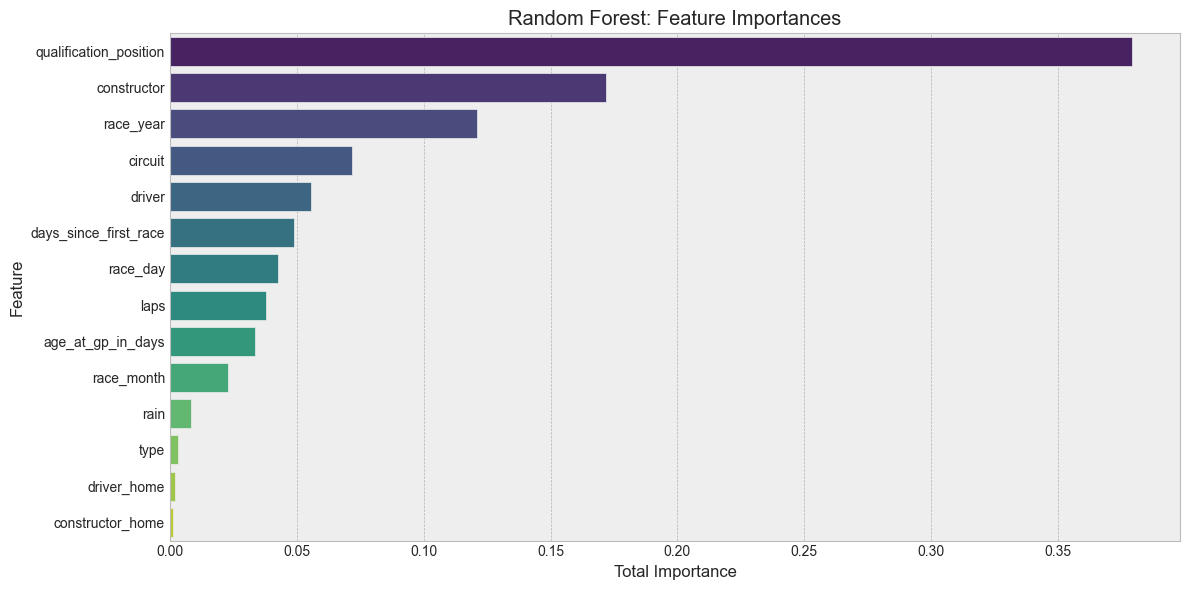

In [40]:
# Get best pipeline from grid search
best_pipeline = best_model_rf

model = best_pipeline.named_steps['model']

num_features = robust_cols

ohe = best_pipeline.named_steps['preprocessing'].named_transformers_['cat']

# Get the feature names for categorical columns
cat_features = ohe.get_feature_names_out(cat_cols)


other_features = other_cols

feature_names = np.concatenate([num_features, cat_features, other_features])


importances = model.feature_importances_


# Step 2: Create DataFrame
feat_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Step 3: Extract base feature name for grouping
def extract_base_feature(name):
    if name in num_features or name in other_features:
        return name
    else:
        return name.split('_')[0]  # e.g., "circuit_Monaco" -> "circuit"

feat_df['Group'] = feat_df['Feature'].apply(extract_base_feature)

# Step 4: Aggregate importance by group
grouped_importance = feat_df.groupby('Group')['Importance'].sum().sort_values(ascending=False).reset_index()

# Step 5: Plot with Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(data=grouped_importance, x='Importance', y='Group', palette='viridis')

plt.title('Random Forest: Feature Importances')
plt.xlabel('Total Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [124]:

# Calculate the weighted position error
wpe = weighted_position_error( test_set_with_result, X_test, best_model_rf)
print(f"Weighted Position Error Random Forest: {wpe:.2f}")

wpe5 = get_top_5_error( test_set_with_result, X_test, best_model_rf)
print(f"Top 5 Weighted Position Error Random Forest: {wpe5:.2f}")

# Calculate general errors
mse, rmse, r2, mae = calculate_general_errors_via_final_position(test_set_with_result, X_test, best_model_rf)
print(f"General Errors Random Forest: MSE: {mse:.2f}, RMSE: {rmse:.2f}, R2: {r2:.4f}, MAE: {mae:.2f}")
mse_top5, rmse_top5, r2_top5, mae_top5 = calculate_general_errors_top5_via_final_position(test_set_with_result, X_test, best_model_rf)
print(f"General Errors Top 5 Random Forest: MSE: {mse_top5:.2f}, RMSE: {rmse_top5:.2f}, R2: {r2_top5:.4f}, MAE: {mae_top5:.2f}")

Weighted Position Error Random Forest: 3.39
Top 5 Weighted Position Error Random Forest: 3.83
General Errors Random Forest: MSE: 7.28, RMSE: 2.70, R2: 0.7085, MAE: 1.83
General Errors Top 5 Random Forest: MSE: 5.42, RMSE: 2.33, R2: -1.7697, MAE: 1.44


In [32]:
# save
# with open('rf.pkl','wb') as f:
#     pickle.dump(best_model_rf,f)

# load
with open('rf.pkl', 'rb') as f:
    best_model_rf = pickle.load(f)


<h5>Gradient boost regressor</h5>

In [41]:
preprocessor = ColumnTransformer([
        ('num', RobustScaler(), robust_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ], remainder='passthrough')
# Full pipeline
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', GradientBoostingRegressor())
])

# GridSearchCV parameters (nested under "model__")
# param_grid = {
#     'model__loss': [ 'huber'],
#     'model__learning_rate': [0.01, 0.1],
#     'model__n_estimators': [ 300, 400],
#     'model__min_samples_split': [ 5, 10, 15],
#     'model__min_samples_leaf': [ 4, 5],
#     'model__max_depth': [ 4, 5],
# }
param_grid ={'model__learning_rate': [0.1], 'model__loss': ['huber'], 'model__max_depth': [5], 'model__min_samples_leaf': [4], 'model__min_samples_split': [5], 'model__n_estimators': [400]}
# Cross-validation
k = 5
cv = KFold(n_splits=k, shuffle=True, random_state=42)

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           cv=cv,
                           scoring='neg_mean_squared_error',
                           verbose=1,
                           n_jobs=-1)

# Fit
grid_search.fit(X_train, y_train)
# Best Parameters: {'model__learning_rate': 0.1, 'model__loss': 'huber', 'model__max_depth': 5, 'model__min_samples_leaf': 4, 'model__min_samples_split': 5, 'model__n_estimators': 400}

# Best model and performance

print("Best Parameters:", grid_search.best_params_)
best_rmse = np.sqrt(-grid_search.best_score_)
print("Best RMSE:", best_rmse)


# Evaluate on training set (optional)

best_model_gb = grid_search.best_estimator_
y_pred = best_model_gb.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Final Model Performance:")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.4f}")
print(f"MAE: {mae:.2f}")



Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Parameters: {'model__learning_rate': 0.1, 'model__loss': 'huber', 'model__max_depth': 5, 'model__min_samples_leaf': 4, 'model__min_samples_split': 5, 'model__n_estimators': 400}
Best RMSE: 49109.885727248446
Final Model Performance:
MSE: 4140465594.47
RMSE: 64346.45
R2: 0.4616
MAE: 39100.32


C:\Users\Admin\AppData\Local\Temp\ipykernel_32612\4262997751.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=grouped_importance, x='Importance', y='Group', palette='viridis')


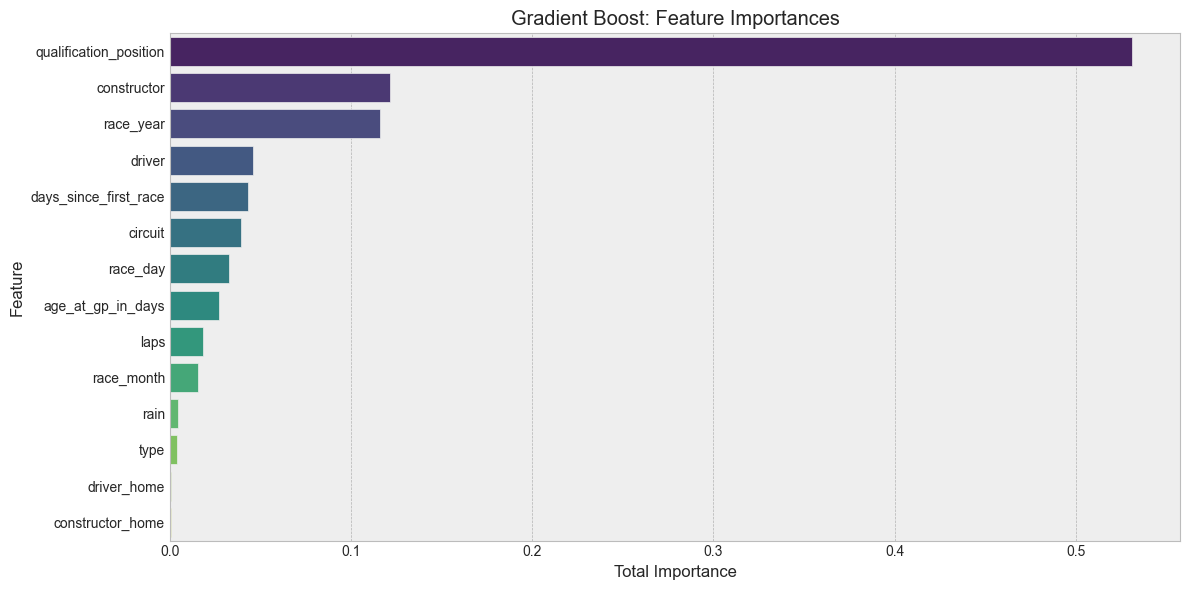

In [42]:
# Get best pipeline from grid search
best_pipeline = best_model_gb

model = best_pipeline.named_steps['model']

num_features = robust_cols

ohe = best_pipeline.named_steps['preprocessing'].named_transformers_['cat']

# Get the feature names for categorical columns
cat_features = ohe.get_feature_names_out(cat_cols)


other_features = other_cols

feature_names = np.concatenate([num_features, cat_features, other_features])


importances = model.feature_importances_
# 5. Create DataFrame for display
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# import seaborn as sns
# import matplotlib.pyplot as plt


# Step 2: Create DataFrame
feat_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Step 3: Extract base feature name for grouping
def extract_base_feature(name):
    if name in num_features or name in other_features:
        return name
    else:
        return name.split('_')[0]  # e.g., "circuit_Monaco" -> "circuit"

feat_df['Group'] = feat_df['Feature'].apply(extract_base_feature)

# Step 4: Aggregate importance by group
grouped_importance = feat_df.groupby('Group')['Importance'].sum().sort_values(ascending=False).reset_index()

# Step 5: Plot with Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(data=grouped_importance, x='Importance', y='Group', palette='viridis')

plt.title('Gradient Boost: Feature Importances')
plt.xlabel('Total Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [127]:
# Calculate the weighted position error
wpe = weighted_position_error( test_set_with_result, X_test, best_model_gb)
print(f"Weighted Position Gradient Boost: {wpe:.2f}")
wpe5 = get_top_5_error( test_set_with_result, X_test, best_model_gb)
print(f"Top 5 Weighted Position Error Gradient Boost: {wpe5:.2f}")
mse, rmse, r2, mae = calculate_general_errors_via_final_position(test_set_with_result, X_test, best_model_gb)
print(f"General Errors Gradient Boost: MSE: {mse:.2f}, RMSE: {rmse:.2f}, R2: {r2:.4f}, MAE: {mae:.2f}")
mse_top5, rmse_top5, r2_top5, mae_top5 = calculate_general_errors_top5_via_final_position(test_set_with_result, X_test, best_model_gb)
print(f"General Errors Top 5 Gradient Boost: MSE: {mse_top5:.2f}, RMSE: {rmse_top5:.2f}, R2: {r2_top5:.4f}, MAE: {mae_top5:.2f}")

Weighted Position Gradient Boost: 3.19
Top 5 Weighted Position Error Gradient Boost: 3.45
General Errors Gradient Boost: MSE: 6.78, RMSE: 2.60, R2: 0.7282, MAE: 1.76
General Errors Top 5 Gradient Boost: MSE: 4.66, RMSE: 2.16, R2: -1.3825, MAE: 1.31


In [128]:
# save
# with open('gb.pkl','wb') as f:
#     pickle.dump(best_model_gb,f)

# load
with open('gb.pkl', 'rb') as f:
    best_model_gb = pickle.load(f)

<h5>Neural network</h5>

In [30]:

preprocessor = ColumnTransformer([
        ('num', RobustScaler(), robust_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ], remainder='passthrough')
# Full pipeline
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', MLPRegressor(random_state=42,max_iter=1000 , verbose=1))
])

# param_grid = {
#     'model__hidden_layer_sizes': [ (50, 50), (100, 50)],
#     'model__activation': ['relu', 'tanh'],
#     'model__alpha': [0.0001, 0.001, 0.01],
#     'model__learning_rate_init': [0.001, 0.01],
#     'model__solver': ['adam'],
# }
param_grid = {
    'model__hidden_layer_sizes': [  (100, 100, 100,100,100)],
    'model__activation': ['relu'],
    'model__alpha': [0.001],
    'model__learning_rate_init': [0.001],
    'model__solver': ['adam'],
}
# Cross-validation
k = 5
cv = KFold(n_splits=k, shuffle=True, random_state=42)

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           cv=cv,
                           scoring='neg_mean_squared_error',
                           verbose=1,
                           n_jobs=-1)


grid_search.fit(X_train, y_train)
# Best Parameters: {'model__activation': 'relu', 'model__alpha': 0.001, 'model__hidden_layer_sizes': (50, 50), 'model__learning_rate_init': 0.001, 'model__solver': 'adam'}

# Best model and performance

print("Best Parameters:", grid_search.best_params_)
best_rmse = np.sqrt(-grid_search.best_score_)
print("Best RMSE:", best_rmse)


# Evaluate on training set (optional)

best_model_nn = grid_search.best_estimator_
y_pred = best_model_nn.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Final Model Performance:")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.4f}")
print(f"MAE: {mae:.2f}")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Iteration 1, loss = 3756691855.89694118
Iteration 2, loss = 3435336290.46694422
Iteration 3, loss = 3422745003.24855804
Iteration 4, loss = 3421954787.57784176
Iteration 5, loss = 3424698594.01518250
Iteration 6, loss = 3420388047.98953104
Iteration 7, loss = 3418010207.17536163
Iteration 8, loss = 3419212636.81274271
Iteration 9, loss = 3418235572.23498726
Iteration 10, loss = 3413996615.39995909
Iteration 11, loss = 3415052979.08573771
Iteration 12, loss = 3412309525.97124386
Iteration 13, loss = 3408980771.42625332
Iteration 14, loss = 3407073287.82758570
Iteration 15, loss = 3401610461.16676188
Iteration 16, loss = 3400135725.90484858
Iteration 17, loss = 3390556720.08406162
Iteration 18, loss = 3372896384.02999687
Iteration 19, loss = 3339746263.90935326
Iteration 20, loss = 3233060306.32413673
Iteration 21, loss = 2813306303.27417088
Iteration 22, loss = 2294875924.30176687
Iteration 23, loss = 2191091319.78028870
Iterati

In [31]:
# Calculate the weighted position error
wpe = weighted_position_error( test_set_with_result, X_test, best_model_nn)
print(f"Weighted Position Neural Network: {wpe:.2f}")
wpe5 = get_top_5_error( test_set_with_result, X_test, best_model_nn)
print(f"Top 5 Weighted Position Error Neural Network: {wpe5:.2f}")

mse, rmse, r2, mae = calculate_general_errors_via_final_position(test_set_with_result, X_test, best_model_nn)
print(f"General Errors Gradient  Neural Network: MSE: {mse:.2f}, RMSE: {rmse:.2f}, R2: {r2:.4f}, MAE: {mae:.2f}")

mse_top5, rmse_top5, r2_top5, mae_top5 = calculate_general_errors_top5_via_final_position(test_set_with_result, X_test, best_model_nn)
print(f"General Errors Top 5 Neural Network: MSE: {mse_top5:.2f}, RMSE: {rmse_top5:.2f}, R2: {r2_top5:.4f}, MAE: {mae_top5:.2f}")

Weighted Position Neural Network: 3.70
Top 5 Weighted Position Error Neural Network: 4.24
General Errors Gradient  Neural Network: MSE: 8.36, RMSE: 2.89, R2: 0.6652, MAE: 2.01
General Errors Top 5 Neural Network: MSE: 5.81, RMSE: 2.41, R2: -1.9687, MAE: 1.59


In [32]:
# save
# with open('nn.pkl','wb') as f:
#     pickle.dump(best_model_nn,f)

# load
with open('nn.pkl', 'rb') as f:
    best_model_nn = pickle.load(f)

<h5>LightGBM</h5>

In [30]:
preprocessor = ColumnTransformer([
        ('num', RobustScaler(), robust_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ], remainder='passthrough')

# Full pipeline
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', LGBMRegressor(random_state=42))
])

# param_grid = {
#     'model__n_estimators': [100, 200, 500],
#     'model__learning_rate': [0.01, 0.05, 0.1],
#     'model__max_depth': [5, 10, 20, -1],  
#     'model__num_leaves': [20, 31, 50, 100],
#     'model__min_child_samples': [5, 10, 20, 30]
# }
param_grid = {
    'model__n_estimators': [ 500],
    'model__learning_rate': [ 0.05],
    'model__max_depth': [ -1],  
    'model__num_leaves': [ 100],
    'model__min_child_samples': [ 20]
}
# Cross-validation
k = 5
cv = KFold(n_splits=k, shuffle=True, random_state=42)

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           cv=cv,
                           scoring='neg_mean_squared_error',
                           verbose=1,
                           n_jobs=-1)


grid_search.fit(X_train, y_train)

# Best Parameters: {'model__learning_rate': 0.05, 'model__max_depth': -1, 'model__min_child_samples': 20, 'model__n_estimators': 500, 'model__num_leaves': 100}
# Best model and performance

print("Best Parameters:", grid_search.best_params_)
best_rmse = np.sqrt(-grid_search.best_score_)
print("Best RMSE:", best_rmse)


# Evaluate on training set (optional)

best_model_lgbm = grid_search.best_estimator_
y_pred = best_model_lgbm.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Final Model Performance:")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.4f}")
print(f"MAE: {mae:.2f}")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000339 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1158
[LightGBM] [Info] Number of data points in the train set: 7469, number of used features: 253
[LightGBM] [Info] Start training from score 27721.687642
Best Parameters: {'model__learning_rate': 0.05, 'model__max_depth': -1, 'model__min_child_samples': 20, 'model__n_estimators': 500, 'model__num_leaves': 100}
Best RMSE: 46984.54328410686
Final Model Performance:
MSE: 4511552015.95
RMSE: 67168.09
R2: 0.4133
MAE: 41821.34


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

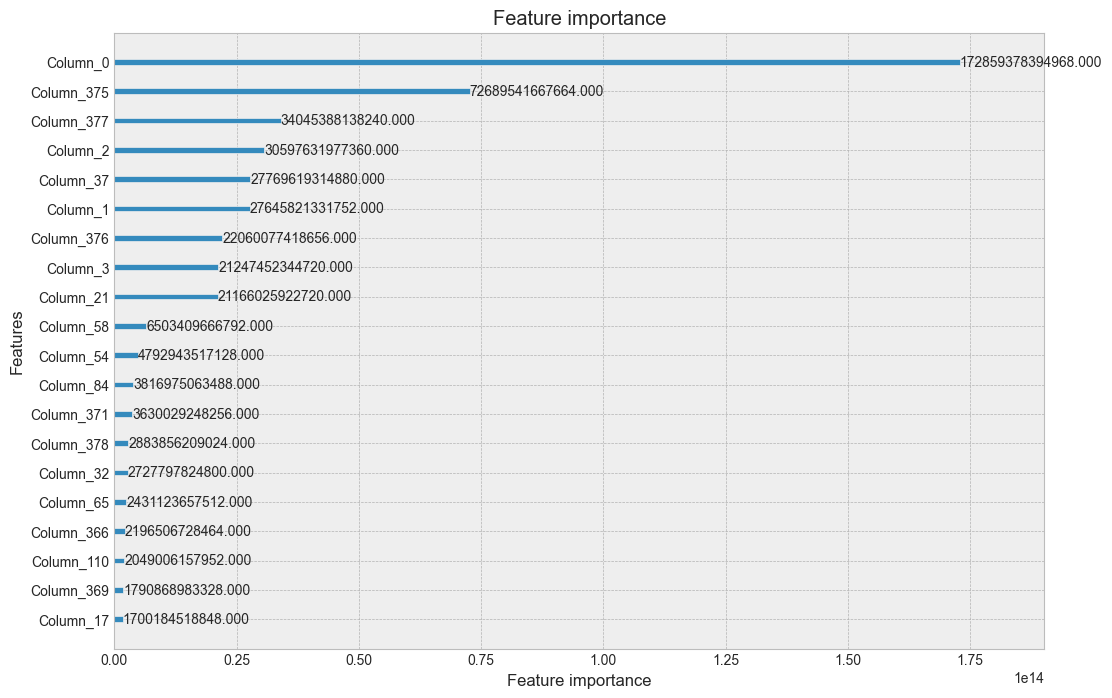

In [35]:
#get model from pipeline
test = best_model_lgbm['model']
plot_importance(test, max_num_features=20, importance_type='gain', figsize=(12, 8))

In [134]:
# Calculate the weighted position error
wpe = weighted_position_error( test_set_with_result, X_test, best_model_lgbm)
print(f"Weighted Position LightGBM: {wpe:.2f}")
wpe5 = get_top_5_error( test_set_with_result, X_test, best_model_lgbm)
print(f"Top 5 Weighted Position Error LightGBM: {wpe5:.2f}")
mse, rmse, r2, mae = calculate_general_errors_via_final_position(test_set_with_result, X_test, best_model_lgbm)
print(f"General Errors Gradient  LightGBM: MSE: {mse:.2f}, RMSE: {rmse:.2f}, R2: {r2:.4f}, MAE: {mae:.2f}")
mse_top5, rmse_top5, r2_top5, mae_top5 = calculate_general_errors_top5_via_final_position(test_set_with_result, X_test, best_model_lgbm)
print(f"General Errors Top 5 LightGBM: MSE: {mse_top5:.2f}, RMSE: {rmse_top5:.2f}, R2: {r2_top5:.4f}, MAE: {mae_top5:.2f}")

Weighted Position LightGBM: 3.49
Top 5 Weighted Position Error LightGBM: 4.01
General Errors Gradient  LightGBM: MSE: 7.49, RMSE: 2.74, R2: 0.7000, MAE: 1.88
General Errors Top 5 LightGBM: MSE: 5.49, RMSE: 2.34, R2: -1.8075, MAE: 1.50


In [135]:
# save
# with open('lgbm.pkl','wb') as f:
#     pickle.dump(best_model_lgbm,f)

# load
with open('lgbm.pkl', 'rb') as f:
    best_model_lgbm = pickle.load(f)